In [1]:
import torch
import os
import torch.nn.functional as F
import torch.nn as nn
from torch.optim import AdamW, lr_scheduler
import pytorch_lightning as pl
from torchvision import models
import torch_pruning as tp
import wandb
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import networkx as nx
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, ColorJitter, RandomCrop



In [2]:
class AlexNetFineTuner(pl.LightningModule):
    def __init__(self, learning_rate=1e-4, num_classes=10):
        super(AlexNetFineTuner, self).__init__()
        self.save_hyperparameters()

        # Load pre-trained AlexNet
        self.model = models.alexnet(pretrained=False)
        self.model.classifier[6] = torch.nn.Linear(4096, num_classes)  # Update the classifier layer

        # Initialize metrics dictionary
        self.metrics = {
            "pruning_percentage": [],
            "test_accuracy": [],
            "test_loss": [],
            "model_size": []
        }
        
        self.test_outputs = []
    def forward(self, x):
        return self.model(x)

    def print_dependency_graph(self, DG):
        print("\nDependency Graph Details:")
        for module, node in DG.module2node.items():
            print(f"Module: {module}")
            for dep in node.dependencies:
                print(f"    * Target Module: {dep.target.module}")

    def visualize_dependency_graph(self, DG):
        """Visualize the dependency graph using networkx."""
        G = nx.DiGraph()
        for module, node in DG.module2node.items():
            for dep in node.dependencies:
                G.add_edge(str(module), str(dep.target.module))
        plt.figure(figsize=(12, 8))
        nx.draw(G, with_labels=True, node_size=1000, font_size=8, node_color="skyblue", edge_color="gray")
        plt.title("Dependency Graph")
        plt.show()

    def prune_model(self, pruning_percentage=0.2, train_loader=None, val_loader=None, fine_tune_epochs=5, fine_tune_lr=1e-5):
        # Prepare example inputs for building the dependency graph
        example_inputs = torch.randn(1, 3, 224, 224, dtype=torch.float32, device="mps")

        # Ensure model is on the correct device and dtype
        self.model = self.model.to("mps").to(torch.float32)

        print("MODEL BEFORE PRUNING:\n", self.model)

        # Build the Dependency Graph
        DG = tp.DependencyGraph().build_dependency(self.model, example_inputs)

        # Layers to prune: you can adjust this as needed
        layers_to_prune = {
            # Skip the first layer: model.features[0]
            "conv2": self.model.features[3],    # second conv layer in AlexNet
            "conv3": self.model.features[6],
            "conv4": self.model.features[8],
            "conv5": self.model.features[10],

            # Skip the last layer: model.classifier[6]
            "fc1": self.model.classifier[1],
            "fc2": self.model.classifier[4]
            # Do not prune fc3 (model.classifier[6]) as it is the final output layer
        }

        # Helper function to compute pruning indices based on magnitude
        def get_pruning_indices(module, percentage):
            with torch.no_grad():
                weight = module.weight.data
                if isinstance(module, torch.nn.Conv2d):
                    # Compute L1 norm of each output channel
                    channel_norms = weight.abs().mean(dim=[1,2,3])  # shape: [out_channels]
                elif isinstance(module, torch.nn.Linear):
                    channel_norms = weight.abs().mean(dim=1)         # shape: [out_features]
                else:
                    return None

                pruning_count = int(channel_norms.size(0) * percentage)
                if pruning_count == 0:
                    return []  # No pruning if percentage is too small

                # Sort indices by magnitude (ascending order)
                _, prune_indices = torch.topk(channel_norms, pruning_count, largest=False)
                return prune_indices.tolist()

        # Collect pruning groups for all layers
        groups = []
        for layer_name, layer_module in layers_to_prune.items():
            if isinstance(layer_module, torch.nn.Conv2d):
                prune_fn = tp.prune_conv_out_channels
                num_features = layer_module.out_channels
            elif isinstance(layer_module, torch.nn.Linear):
                prune_fn = tp.prune_linear_out_channels
                num_features = layer_module.out_features
            else:
                print(f"Skipping {layer_name}: Unsupported layer type {type(layer_module)}")
                continue

            # Get pruning indices based on magnitude
            pruning_idxs = get_pruning_indices(layer_module, pruning_percentage)
            if pruning_idxs is None or len(pruning_idxs) == 0:
                # No pruning indices determined, skip this layer
                print(f"No channels to prune for {layer_name}.")
                continue

            # Build the pruning group
            group = DG.get_pruning_group(layer_module, prune_fn, idxs=pruning_idxs)
            # Check if group is valid
            if DG.check_pruning_group(group):
                groups.append((layer_name, group))
            else:
                print(f"Invalid pruning group for layer {layer_name}, skipping pruning.")

        # Prune all layers together if we have at least one valid group
        if groups:
            print(f"Pruning with {pruning_percentage*100}% percentage on {len(groups)} layers...")
            for layer_name, group in groups:
                print(f"Pruning layer: {layer_name}")
                group.prune()

            print("MODEL AFTER PRUNING:\n", self.model)
        else:
            print("No valid pruning groups found. The model was not pruned.")
            return

        # Update metrics after pruning
        pruned_num_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        self.metrics["model_size"].append(pruned_num_params)
        self.metrics["pruning_percentage"].append(pruning_percentage * 100)

        # Optional fine-tuning after pruning
        if train_loader is not None and val_loader is not None:
            print("Starting fine-tuning of the pruned model...")
            self.fine_tune_model(self.model, train_loader, val_loader, fine_tune_epochs, fine_tune_lr)
        else:
            print("No train/val loaders provided for fine-tuning.")

        # # Perform testing after pruning
        # if hasattr(self, "trainer"):
        #     print("Testing the pruned model...")
        #     self.trainer.test(self)
        # else:
        #     print("Trainer is not set. Testing skipped.")

    def training_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS

        print("Images device and dtype:---------------------", images.device, images.dtype)
        print("Labels device and dtype:", labels.device, labels.dtype)

        outputs = self(images)
        loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        acc = (preds == labels).float().mean()
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)  # Convert inputs to float32
        labels = labels.to("mps")  # Ensure labels are on MPS
        outputs = self(images)
        val_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        val_acc = (preds == labels).float().mean()
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
        return val_loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        images = images.to(torch.float32)
        labels = labels.to("mps")
        outputs = self(images)
        test_loss = F.cross_entropy(outputs, labels)
        preds = torch.argmax(outputs, dim=1)
        test_acc = (preds == labels).float().mean()

        print(f"Test Step: Batch {batch_idx}, Loss: {test_loss.item()}, Acc: {test_acc.item()}")

        # Store batch results for aggregation later
        self.test_outputs.append({"test_loss": test_loss.item(), "test_acc": test_acc.item()})

        # Log per-batch results if needed
        self.log("test_loss_batch", test_loss, prog_bar=True)
        self.log("test_acc_batch", test_acc, prog_bar=True)

        return test_loss

    def on_test_epoch_end(self):
        # Aggregate metrics across batches
        avg_loss = sum(o["test_loss"] for o in self.test_outputs) / len(self.test_outputs)
        avg_acc = sum(o["test_acc"] for o in self.test_outputs) / len(self.test_outputs)

        print(f"Test Epoch End: Avg Loss: {avg_loss}, Avg Acc: {avg_acc}")

        # Append aggregated metrics for the epoch
        self.metrics["test_accuracy"].append(avg_acc)
        self.metrics["test_loss"].append(avg_loss)

        # Log aggregated metrics
        self.log("test_loss_epoch", avg_loss, prog_bar=True)
        self.log("test_acc_epoch", avg_acc, prog_bar=True)

        # Clear outputs for the next test epoch
        self.test_outputs = []


    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}
    
    def fine_tune_model(self, model, train_loader, val_loader, epochs=5, learning_rate=1e-5):
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
        loss_fn = torch.nn.CrossEntropyLoss()

        for epoch in range(epochs):
            # Training phase
            model.train()
            train_loss, train_correct = 0, 0
            for images, labels in train_loader:
                images, labels = images.to("mps"), labels.to("mps")
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_correct += (outputs.argmax(dim=1) == labels).sum().item()

            # Validation phase
            model.eval()
            val_loss, val_correct = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to("mps"), labels.to("mps")
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    val_correct += (outputs.argmax(dim=1) == labels).sum().item()

            # Compute metrics
            train_acc = train_correct / len(train_loader.dataset)
            val_acc = val_correct / len(val_loader.dataset)

            print(f"Epoch {epoch + 1}/{epochs}, "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            # Instead of self.log, just print or store the metrics
            print(f"fine_tune_train_loss: {train_loss}, fine_tune_train_acc: {train_acc}, "
            f"fine_tune_val_loss: {val_loss}, fine_tune_val_acc: {val_acc}")





In [3]:
def plot_metrics(metrics):
    print("Metrics Debug:")
    print("Pruning Percentages:", metrics["pruning_percentage"])
    print("Test Accuracy:", metrics["test_accuracy"])
    print("Test Loss:", metrics["test_loss"])
    print("Model Size:", metrics["model_size"])

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_accuracy"], marker='o', label="Accuracy")
    plt.title("Test Accuracy vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["test_loss"], marker='o', color="orange", label="Loss")
    plt.title("Test Loss vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(metrics["pruning_percentage"], metrics["model_size"], marker='o', color="green", label="Model Size")
    plt.title("Model Size vs. Pruning Percentage")
    plt.xlabel("Pruning Percentage (%)")
    plt.ylabel("Number of Parameters")
    plt.grid(True)
    plt.legend()
    plt.show()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: p-mangal (p-mangal-university-of-amsterdam). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
Applying 0% pruning...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MODEL BEFORE PRUNING:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_feat

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


No channels to prune for conv2.
No channels to prune for conv3.
No channels to prune for conv4.
No channels to prune for conv5.
No channels to prune for fc1.
No channels to prune for fc2.
No valid pruning groups found. The model was not pruned.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Test Step: Batch 0, Loss: 0.2509228587150574, Acc: 0.875
Test Step: Batch 1, Loss: 0.6664508581161499, Acc: 0.75
Test Step: Batch 2, Loss: 0.14565804600715637, Acc: 0.96875
Test Step: Batch 3, Loss: 0.14597974717617035, Acc: 0.9375
Test Step: Batch 4, Loss: 0.33735790848731995, Acc: 0.875
Test Step: Batch 5, Loss: 0.33468544483184814, Acc: 0.875
Test Step: Batch 6, Loss: 0.4016116261482239, Acc: 0.8125
Test Step: Batch 7, Loss: 0.38849732279777527, Acc: 0.8125
Test Step: Batch 8, Loss: 0.33743956685066223, Acc: 0.875
Test Step: Batch 9, Loss: 0.4619462788105011, Acc: 0.875
Test Step: Batch 10, Loss: 0.16078560054302216, Acc: 0.90625
Test Step: Batch 11, Loss: 0.5173378586769104, Acc: 0.875
Test Step: Batch 12, Loss: 0.18343600630760193, Acc: 0.96875
Test Step: Batch 13, Loss: 0.39655038714408875, Acc: 0.875
Test Step: Batch 14, Loss: 0.4296382665634155, Acc: 0.875
Test Step: Batch 15, Loss: 0.2102338671684265, Acc: 0.90625
Test Step: Batch 16, Loss: 0.15239331126213074, Acc: 0.9375
Tes

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.8891000151634216     │
│      test_acc_epoch       │    0.8889776468276978     │
│      test_loss_batch      │    0.3239855468273163     │
│      test_loss_epoch      │    0.32431888580322266    │
└───────────────────────────┴───────────────────────────┘

Pruned model saved to: ./pruned_models/alexnet_pruned_0.pth
Applying 10.0% pruning...
MODEL BEFORE PRUNING:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequent

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 5/5, Train Loss: 43.9773, Train Acc: 0.9884, Val Loss: 16.6982, Val Acc: 0.9809
fine_tune_train_loss: 43.97728461009683, fine_tune_train_acc: 0.988375, fine_tune_val_loss: 16.698215505864937, fine_tune_val_acc: 0.9809


Testing: |          | 0/? [00:00<?, ?it/s]

Test Step: Batch 0, Loss: 0.2353406548500061, Acc: 0.90625
Test Step: Batch 1, Loss: 0.47155535221099854, Acc: 0.84375
Test Step: Batch 2, Loss: 0.11660731583833694, Acc: 0.9375
Test Step: Batch 3, Loss: 0.2313080132007599, Acc: 0.96875
Test Step: Batch 4, Loss: 0.4827251732349396, Acc: 0.875
Test Step: Batch 5, Loss: 0.15364140272140503, Acc: 0.90625
Test Step: Batch 6, Loss: 0.22510391473770142, Acc: 0.9375
Test Step: Batch 7, Loss: 0.36068594455718994, Acc: 0.90625
Test Step: Batch 8, Loss: 0.28854310512542725, Acc: 0.875
Test Step: Batch 9, Loss: 0.543822705745697, Acc: 0.90625
Test Step: Batch 10, Loss: 0.06627710908651352, Acc: 0.96875
Test Step: Batch 11, Loss: 0.5636931657791138, Acc: 0.875
Test Step: Batch 12, Loss: 0.2616874873638153, Acc: 0.90625
Test Step: Batch 13, Loss: 0.3305729329586029, Acc: 0.90625
Test Step: Batch 14, Loss: 0.3757350444793701, Acc: 0.875
Test Step: Batch 15, Loss: 0.08050540834665298, Acc: 0.96875
Test Step: Batch 16, Loss: 0.21982386708259583, Acc: 

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.9172000288963318     │
│      test_acc_epoch       │    0.9172324538230896     │
│      test_loss_batch      │    0.31430694460868835    │
│      test_loss_epoch      │    0.31398266553878784    │
└───────────────────────────┴───────────────────────────┘

Pruned model saved to: ./pruned_models/alexnet_pruned_10.pth
Applying 20.0% pruning...
MODEL BEFORE PRUNING:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequen

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 5/5, Train Loss: 87.6036, Train Acc: 0.9761, Val Loss: 27.5761, Val Acc: 0.9693
fine_tune_train_loss: 87.6036290852353, fine_tune_train_acc: 0.97615, fine_tune_val_loss: 27.576124089129735, fine_tune_val_acc: 0.9693


Testing: |          | 0/? [00:00<?, ?it/s]

Test Step: Batch 0, Loss: 0.06854479014873505, Acc: 0.96875
Test Step: Batch 1, Loss: 0.4806770384311676, Acc: 0.90625
Test Step: Batch 2, Loss: 0.24610036611557007, Acc: 0.90625
Test Step: Batch 3, Loss: 0.1946924775838852, Acc: 0.96875
Test Step: Batch 4, Loss: 0.48289403319358826, Acc: 0.9375
Test Step: Batch 5, Loss: 0.1844998151063919, Acc: 0.90625
Test Step: Batch 6, Loss: 0.2520820200443268, Acc: 0.9375
Test Step: Batch 7, Loss: 0.4170878231525421, Acc: 0.875
Test Step: Batch 8, Loss: 0.24026326835155487, Acc: 0.90625
Test Step: Batch 9, Loss: 0.5695196986198425, Acc: 0.875
Test Step: Batch 10, Loss: 0.0429709255695343, Acc: 0.96875
Test Step: Batch 11, Loss: 0.7567567825317383, Acc: 0.8125
Test Step: Batch 12, Loss: 0.30148497223854065, Acc: 0.90625
Test Step: Batch 13, Loss: 0.30526769161224365, Acc: 0.875
Test Step: Batch 14, Loss: 0.40144094824790955, Acc: 0.875
Test Step: Batch 15, Loss: 0.12498054653406143, Acc: 0.9375
Test Step: Batch 16, Loss: 0.1747877597808838, Acc: 0.

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.9136999845504761     │
│      test_acc_epoch       │    0.9137380123138428     │
│      test_loss_batch      │    0.3068220019340515     │
│      test_loss_epoch      │    0.30652135610580444    │
└───────────────────────────┴───────────────────────────┘

Pruned model saved to: ./pruned_models/alexnet_pruned_20.pth
Applying 30.0% pruning...
MODEL BEFORE PRUNING:
 AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequen

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Epoch 5/5, Train Loss: 162.0890, Train Acc: 0.9553, Val Loss: 45.5177, Val Acc: 0.9491
fine_tune_train_loss: 162.0890440880321, fine_tune_train_acc: 0.955275, fine_tune_val_loss: 45.51766524463892, fine_tune_val_acc: 0.9491


Testing: |          | 0/? [00:00<?, ?it/s]

Test Step: Batch 0, Loss: 0.059323281049728394, Acc: 1.0
Test Step: Batch 1, Loss: 0.4399348497390747, Acc: 0.84375
Test Step: Batch 2, Loss: 0.21744342148303986, Acc: 0.875
Test Step: Batch 3, Loss: 0.14900285005569458, Acc: 0.96875
Test Step: Batch 4, Loss: 0.381072998046875, Acc: 0.875
Test Step: Batch 5, Loss: 0.3285273015499115, Acc: 0.875
Test Step: Batch 6, Loss: 0.2201176881790161, Acc: 0.90625
Test Step: Batch 7, Loss: 0.37109798192977905, Acc: 0.875
Test Step: Batch 8, Loss: 0.3049639165401459, Acc: 0.875
Test Step: Batch 9, Loss: 0.4753340482711792, Acc: 0.9375
Test Step: Batch 10, Loss: 0.08195823431015015, Acc: 0.96875
Test Step: Batch 11, Loss: 0.5815433263778687, Acc: 0.8125
Test Step: Batch 12, Loss: 0.14953097701072693, Acc: 0.90625
Test Step: Batch 13, Loss: 0.1979568898677826, Acc: 0.9375
Test Step: Batch 14, Loss: 0.5323500633239746, Acc: 0.8125
Test Step: Batch 15, Loss: 0.11979176849126816, Acc: 0.9375
Test Step: Batch 16, Loss: 0.07278447598218918, Acc: 0.96875
T

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_batch       │    0.9035999774932861     │
│      test_acc_epoch       │     0.903654158115387     │
│      test_loss_batch      │     0.307637095451355     │
│      test_loss_epoch      │    0.30729880928993225    │
└───────────────────────────┴───────────────────────────┘

Pruned model saved to: ./pruned_models/alexnet_pruned_30.pth
Metrics Debug:
Pruning Percentages: [30.0]
Test Accuracy: [0.9036541533546326]
Test Loss: [0.30729881318184893]
Model Size: [28138765]


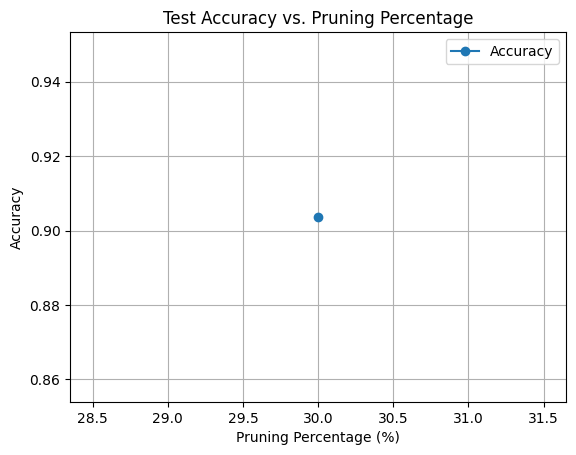

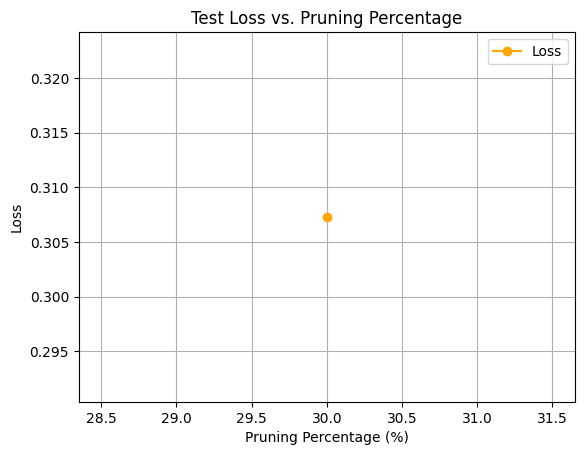

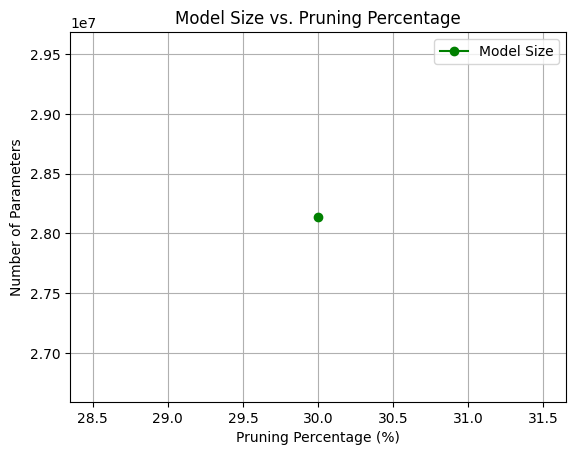

epoch,▁▁▁▁
test_acc_batch,▁█▇▅
test_acc_epoch,▁█▇▅
test_loss_batch,█▄▁▁
test_loss_epoch,█▄▁▁
trainer/global_step,▁▁▁▁
epoch,0
test_acc_batch,0.9036
test_acc_epoch,0.90365
test_loss_batch,0.30764
test_loss_epoch,0.3073


In [4]:
def main():
    wandb.init(project='alexnet_depGraph', name='AlexNet_Run')
    wandb_logger = WandbLogger(log_model=False)

    transform = Compose([
        Resize((224, 224)),
        ToTensor(),
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Load datasets
    full_train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

    # Create train/validation split
    train_size = int(0.8 * len(full_train_dataset))
    val_size = len(full_train_dataset) - train_size
    train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)
    test_dataloader = DataLoader(test_dataset, batch_size=32)

    checkpoint_path = "../checkpointsAlex/checkpoint_with_aug_epoch5.ckpt"

    # Define pruning percentages
    # pruning_percentages = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
    pruning_percentages = [0.1, 0.3, 0.5]

    os.makedirs('./pruned_models/', exist_ok=True)

    for pruning_percentage in pruning_percentages:
        print(f"Applying {pruning_percentage * 100}% pruning...")
        
        # Reload the original model from checkpoint each time
        model = AlexNetFineTuner.load_from_checkpoint(checkpoint_path).to("mps").to(torch.float32)

        # Prune the model and fine-tune it (fine-tuning is done inside prune_model if train_loader and val_loader are passed)
        model.prune_model(pruning_percentage=pruning_percentage, 
                          train_loader=train_dataloader, 
                          val_loader=val_dataloader, 
                          fine_tune_epochs=5, 
                          fine_tune_lr=1e-5)

        # Test the pruned (and potentially fine-tuned) model
        trainer = pl.Trainer(max_epochs=5, logger=wandb_logger)
        trainer.test(model, dataloaders=test_dataloader)

        # Save the pruned model to disk
        model.zero_grad()  # Clear gradients to reduce file size
        pruned_model_path = f"./pruned_models/alexnet_pruned_{int(pruning_percentage * 100)}.pth"
        torch.save(model, pruned_model_path)
        print(f"Pruned model saved to: {pruned_model_path}")

    # Plot metrics after all pruning iterations
    plot_metrics(model.metrics)
    wandb.finish()


if __name__ == "__main__":
    main()


In [7]:
import os
import torch

def list_pruned_models(directory='./pruned_models/'):
    # List all files in the directory
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pth')]

pruned_models = list_pruned_models()
print("Available Pruned Models:", pruned_models)


Available Pruned Models: ['./pruned_models/alexnet_pruned_10.pth', './pruned_models/alexnet_pruned_0.pth', './pruned_models/alexnet_pruned_20.pth', './pruned_models/alexnet_pruned_30.pth']


In [10]:
def load_pruned_model(model_path):
    print(f"Loading pruned model from: {model_path}")
    model = torch.load(model_path)
    model = model.to("mps").to(torch.float32)  # Move to MPS if needed
    return model

# Example: Load a pruned model with 30% pruning
pruned_model_path = "./pruned_models/alexnet_pruned_10.pth"
pruned_model = load_pruned_model(pruned_model_path)

# Verify the loaded model
print(pruned_model)


Loading pruned model from: ./pruned_models/alexnet_pruned_10.pth


/var/folders/wc/wpc2_w2s73z_8qr0dbq576x00000gn/T/ipykernel_81511/2172303324.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path)


AlexNetFineTuner(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 173, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(173, 346, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(346, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(231, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MODEL AFTER REBUILDING:
 AlexNetFineTuner(
  (model): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 173, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(173, 346, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(346, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(231, 231, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropo